In [ ]:
!gdown 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0 -O "data/weather.zip"
!unzip data/weather.zip -d data
!rm data/weather.zip

In [20]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## Setting Random Seed for Reproducibility

In [21]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## Data Preparation

In [22]:
root_dir = "data/weather-dataset/dataset"

# Mapping class names to numeric labels
classes = {
    label_idx: class_name for label_idx, class_name in enumerate(os.listdir(root_dir))
}

In [23]:
classes.items()

dict_items([(0, 'dew'), (1, 'hail'), (2, 'snow'), (3, 'glaze'), (4, 'rain'), (5, 'rime'), (6, 'lightning'), (7, 'frost'), (8, 'sandstorm'), (9, 'rainbow'), (10, 'fogsmog')])

Loading image paths and labels

In [24]:
img_paths, labels = [], []

for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

In [25]:
img_paths[:5], labels[:5]

(['weather-dataset/dataset/dew/2324.jpg',
  'weather-dataset/dataset/dew/2796.jpg',
  'weather-dataset/dataset/dew/2340.jpg',
  'weather-dataset/dataset/dew/2553.jpg',
  'weather-dataset/dataset/dew/2435.jpg'],
 [0, 0, 0, 0, 0])

Splitting Data into Training, Validation, and Test Sets

In [26]:
X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=0.2,
    random_state=seed,
    shuffle=True
)

X_train, X_test, y_train, y_test = train_test_split(
    img_paths, labels,
    test_size=0.125,
    random_state=seed,
    shuffle=True
)

Defining a custom WeatherDataset class for loading images with transformations

In [27]:
class WeatherDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.img_paths = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]

        return img, label

In [28]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    # Convert the image to a NumPy array and select the RGB channels (first 3 channels)
    img = np.array(img)[..., :3]
    
    # Convert the image to a PyTorch tensor and change the shape to (channels, height, width)
    img = torch.tensor(img).permute(2, 0, 1).float()
    
    # Normalize the image by dividing pixel values by 255, scaling them to the range [0, 1]
    normalized_img = img / 255.0
    return normalized_img

In [29]:
train_dataset = WeatherDataset(X_train, y_train, transform=transform)
val_dataset = WeatherDataset(X_val, y_val, transform=transform)
test_dataset = WeatherDataset(X_test, y_test, transform=transform)

len(train_dataset), len(val_dataset), len(test_dataset)

(6004, 1373, 858)

Creating DataLoaders for training, validation, and test sets

In [30]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)

(12, 172, 108)

## ResNet Training and Evaluation

### Training and Evaluation Functions for Model

In [34]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct, total = 0, 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            # Calculate predictions
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    # Calculate average loss and accuracy
    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc

In [35]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() # Backpropagation
            optimizer.step() # Update weights

            batch_train_losses.append(loss.item())

            _, preds = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        # Calculate average training loss for the epoch
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate the model
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch + 1}/{epochs}:\t"
            f"Train Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\t"
            f"Val Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}"
        )

    return train_losses, train_accuracies, val_losses, val_accuracies

### ResNet Model Implementation

In [31]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)
        return x

In [32]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)

        self.avgpool = nn.AvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)
        return block_sequential

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x


### Training model

In [33]:
n_classes = len(list(classes.keys()))

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNet(residual_block=ResidualBlock, n_blocks_lst=[2, 2, 2, 2], n_classes=n_classes).to(device)

In [36]:
epochs = 35
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
train_losses, train_accuracies, val_losses, val_accuracies = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=epochs
)

Epoch 1/35:	Train Loss: 1.8018	Train Acc: 0.3987	Val Loss: 2.3852	Val Acc: 0.1173
Epoch 2/35:	Train Loss: 1.1981	Train Acc: 0.6209	Val Loss: 2.3562	Val Acc: 0.1500
Epoch 3/35:	Train Loss: 0.9285	Train Acc: 0.7185	Val Loss: 1.9872	Val Acc: 0.3430
Epoch 4/35:	Train Loss: 0.7382	Train Acc: 0.7966	Val Loss: 1.3631	Val Acc: 0.5615
Epoch 5/35:	Train Loss: 0.6165	Train Acc: 0.8383	Val Loss: 0.8897	Val Acc: 0.7167
Epoch 6/35:	Train Loss: 0.4681	Train Acc: 0.8944	Val Loss: 0.9715	Val Acc: 0.6977
Epoch 7/35:	Train Loss: 0.3596	Train Acc: 0.9287	Val Loss: 0.9310	Val Acc: 0.7043
Epoch 8/35:	Train Loss: 0.2654	Train Acc: 0.9555	Val Loss: 0.8698	Val Acc: 0.7363
Epoch 9/35:	Train Loss: 0.1833	Train Acc: 0.9758	Val Loss: 0.6769	Val Acc: 0.7961
Epoch 10/35:	Train Loss: 0.1327	Train Acc: 0.9840	Val Loss: 0.5909	Val Acc: 0.8172
Epoch 11/35:	Train Loss: 0.0971	Train Acc: 0.9905	Val Loss: 0.6005	Val Acc: 0.8128
Epoch 12/35:	Train Loss: 0.0758	Train Acc: 0.9955	Val Loss: 0.6101	Val Acc: 0.8135
Epoch 13/35:	

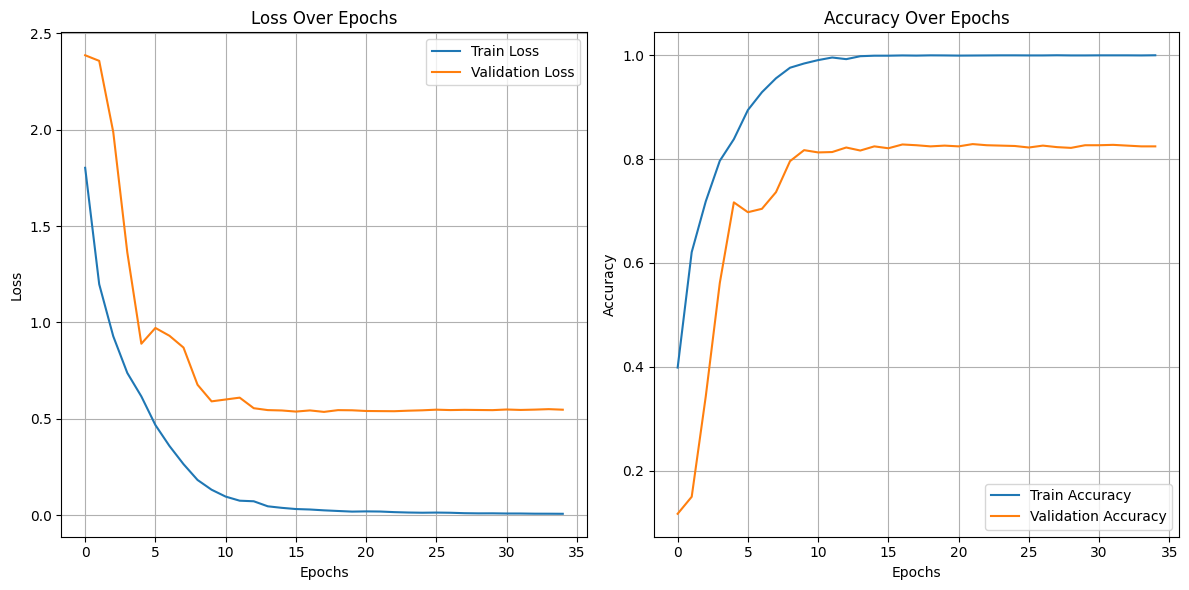

In [42]:
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Evaluation model

In [38]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset:")
print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Evaluation on val/test dataset:
Validation accuracy:  0.8244719592134013
Test accuracy:  0.7191142191142191
